In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from causal_meta.modules.mdn import mdn_nll
from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from models import mdn, gmm, auc_transfer_metric
from argparse import Namespace

In [3]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

In [4]:
opt = Namespace()
# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10
# Training
opt.LR = 0.001
opt.NUM_ITER = 3000
opt.CUDA = False
opt.REC_FREQ = 10
# Meta
opt.ALPHA_LR = 0.1
opt.ALPHA_NUM_ITER = 500
opt.FINETUNE_LR = 0.001
opt.FINETUNE_NUM_ITER = 10
opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)

In [5]:
scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

In [6]:
model_x2y = mdn(opt)
frames_x2y = train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, polarity='X2Y',
    loss_fn=mdn_nll, decoder=None, encoder=None)

In [7]:
model_y2x = mdn(opt)
frames_y2x = train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, polarity='Y2X',
    loss_fn=mdn_nll, decoder=None, encoder=None)

In [8]:
alpha = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, None, None, alpha, scm, 
                           opt.PARAM_DISTRY, opt.PARAM_SAMPLER, mdn_nll,
                           auc_transfer_metric, mixmode='logsigp')

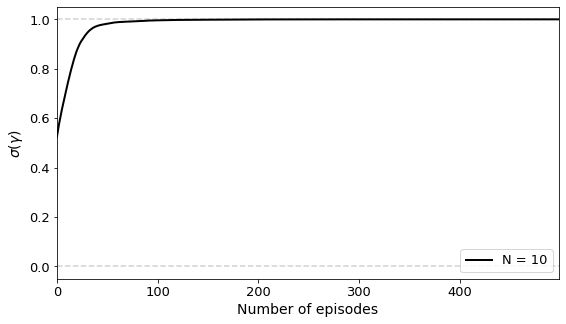

In [9]:
alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alphas, lw=2, color='k', label='N = {0}'.format(10))

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()